In [5]:
import sys
from pathlib import Path
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np


##import 
sys.path.insert(0, os.path.join(os.path.dirname(os.path.abspath("")),"Code","Travis"))
import utils
import plotting
import responses_analysis
import importlib
import dfof
import config

save_path = config.save_path
data_path = config.data_path
if not save_path.exists():
    save_path.mkdir()


def signalCorrelations_v3(unmixed, isResponsive, numBaseline=15, window = [15,45], freqToUse = [0,1,2,3,4], attenToUse=[0,1,2,3]):
    ##only look at low frequencies
    responsiveNeurons = list(isResponsive[isResponsive['isResponsive']==True]['neuron'])
    unmixed_mean = unmixed.mean(axis=-1)
    bl_subt = unmixed_mean[:,window[0]:window[1],:] - unmixed_mean[:,:numBaseline,:].mean(axis=1, keepdims=True)

    corrmaps = []
    for freq in freqToUse:
        for atten in attenToUse:
            corrmaps.append(np.corrcoef(bl_subt[responsiveNeurons,:,freq,atten]))
    corrmap = np.stack(corrmaps).mean(axis=0)   

    neuron1 = []
    neuron2 = []
    corrs = []
    for i, n1 in enumerate(responsiveNeurons):
        for j, n2 in enumerate(responsiveNeurons):
            if i != j & j < i:
                neuron1.append(n2)
                neuron2.append(n1)
                corrs.append(corrmap[i,j])

    df = pd.DataFrame({'neuron1':neuron1, 'neuron2':neuron2, 'corrs':corrs})
    return df

In [6]:
###load in 2P data
test = utils.findUnanalyzedStacks(data_path, pattern="**/2P/L23/[0-9]*", foldername="all")
twop_mice = responses_analysis.get2Pmice(data_path, test)

**/2P/L23/[0-9]* all


In [11]:
sig_responding_neurons = []
total_neurons = []
meancorrs = []
noisecorrs = []
allcorrs = []
force = False

for index, row in twop_mice.iterrows():
    print(row['Mouse'])
    analysis_dir = row['2P_path'] / "response_analysis"
    if not analysis_dir.exists():
        (row['2P_path'] / "response_analysis").mkdir()

    if (analysis_dir / "unmixed.npy").exists():
        unmixed = np.load(analysis_dir / "unmixed.npy")
    else:
        temp = dfof.processFluor(dir = row['2P_path'])
        temp.loadTraces()
        temp.calc_dfof(window=500, step = 50, percentile=10, cutoff = 20)
        temp.unmix(numBaseline=15, framesAfter=60)
        np.save(analysis_dir / "unmixed.npy", temp.unmixed)

    responsive_file = analysis_dir / "isResponsive.csv"
    if responsive_file.exists():
        isResponsive = pd.read_csv(responsive_file)
    else:
        isResponsive = responses_analysis.isResponsive(unmixed, alpha = 0.01)
        isResponsive.to_csv(responsive_file, index=False)

    ####now which responses are sound responsive?
    ## signalCorrelations
    signalcorr_file = analysis_dir / "signalCorrelations_lowFreq.csv" 
    if signalcorr_file.exists() and not force:
        signalcorr = pd.read_csv(signalcorr_file)
    else:
        print("running signal correlations")
        signalcorr = signalCorrelations_v3(unmixed, isResponsive, freqToUse = [0,1,2], attenToUse = [0,1])
        signalcorr.to_csv(signalcorr_file, index=False)

    ##noise correlations
    noisecorr_file = analysis_dir / "noiseCorrelations.csv" 
    if noisecorr_file.exists():
        noisecorr = pd.read_csv(noisecorr_file)
    else:
        print("running noise correlations")
        noisecorr = noiseCorrelations(unmixed, isResponsive)
        noisecorr.to_csv(noisecorr_file, index=False)

    
    sig_responding_neurons.append(isResponsive['isResponsive'].value_counts().loc[True])
    total_neurons.append(isResponsive.shape[0])
    meancorrs.append(signalcorr['corrs'].mean())
    noisecorrs.append(noisecorr['noise_corrs'].mean())

twop_mice['total_neurons'] = total_neurons
twop_mice['sig_responders'] = sig_responding_neurons
twop_mice['sound_responsive_percent'] = twop_mice['sig_responders'] / twop_mice['total_neurons'] * 100
twop_mice['signalCorr'] = meancorrs
twop_mice['noiseCorr'] = noisecorrs

m602
m603
m609
m670
m674
m675
m659
m722
m664
m666
m900
m984
m985
m1315
m1321
m1318
m1323
m1493
m1937
m2065
m1983


C:\Users\travisb\AppData\Local\Temp\ipykernel_25252\2515023318.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['ahl B6','Ahl+ B6','Ahl+\nCBA.B6'], ha='center',x=0)


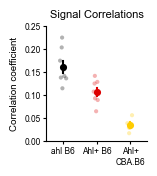

In [16]:
color_dict = config.color_dict
order = config.order
np.random.seed(51)

fig, ax = plt.subplots(figsize=(1.3,1.5))

sns.pointplot(twop_mice, y="signalCorr", x = "Genotype", hue = "Genotype", order = order, palette=color_dict, markersize=4, linewidth = 1.5, errorbar='se')

#sns.boxplot(twop_mice, y="signalCorr",  x="Genotype", hue = "Genotype", order =order , palette=color_dict, fill = False, saturation=0.75, width = 0.2, linewidth=1.5, showcaps=False)
sns.stripplot(data = twop_mice, y="signalCorr", x = "Genotype", hue = "Genotype", marker='o', size=3, legend = None, palette=color_dict, alpha = 0.3)
#sns.catplot(data = twop_mice, x="signalCorr", y = "Genotype", hue = "Genotype", palette= color_dict, estimator='Mean',order = order, ax=g)
#sns.stripplot(twop_mice, x="Genotype", y = "total_offset_prop", hue = "Genotype", marker='o', size=3, legend = None, palette=color_dict, alpha = 0.3)

plt.ylim([0,.25])
plt.yticks(np.arange(0,.26,0.05))
ax.set_xticklabels(['ahl B6','Ahl+ B6','Ahl+\nCBA.B6'], ha='center',x=0)
ax.set_xlabel("")
ax.set_ylabel("Correlation coefficient", fontsize = 7)
ax.set_title("Signal Correlations")
ax.title.set_size(8)
fig, ax = plotting.figQuality(fig, ax)
plt.savefig(save_path / "SF3_D_signalCorrelations_lowFreq_higher_sound_level.svg")
#plt.set_figwidth(3.5)



In [14]:
model = ols('signalCorr ~ C(Genotype) + C(Sex) + C(Genotype):C(Sex)', data=twop_mice).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Genotype),0.048208,2.0,41.015181,8.296159e-07
C(Sex),0.002520,1.0,4.287982,5.605067e-02
C(Genotype):C(Sex),0.003470,2.0,2.952692,8.293702e-02
Residual,0.008815,15.0,NaN,NaN


In [15]:
import stats
stats.ttests_within(twop_mice, dv_cat="signalCorr")

('Thy1-GC6s; Cdh23 (Ahl/ahl)', 'Thy1-GC6s; Cdh23 (ahl/ahl)')
('Thy1-GC6s; Cdh23 (Ahl/ahl)', '(F1) Thy1-GC6s; Cdh23 (Ahl/ahl)')
('Thy1-GC6s; Cdh23 (ahl/ahl)', '(F1) Thy1-GC6s; Cdh23 (Ahl/ahl)')


,geno1,geno2,mean1,std1,mean2,std2,pval,reject_hs,pval_corrected
0,Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),0.106198,0.024696,0.160495,0.037211,0.003993,True,0.003993
1,Thy1-GC6s; Cdh23 (Ahl/ahl),(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),0.106198,0.024696,0.033873,0.014522,0.000105,True,0.000158
2,Thy1-GC6s; Cdh23 (ahl/ahl),(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),0.160495,0.037211,0.033873,0.014522,0.000018,True,0.000054
